In [1]:
# library imports
import pandas as pd
import pandas_gbq
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt

from jobspy import scrape_jobs

import torch._dynamo
torch._dynamo.config.suppress_errors = True
from gliner import GLiNER

/home/shilpa/miniforge3/envs/liscrape/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Scraping Indeed data engineer job postings
Library reference: [JobSpy](https://github.com/Bunsly/JobSpy)

In [2]:
# call function to scrape jobs
indeed_jobs = scrape_jobs(
    site_name=["indeed"],
    search_term='"data engineer"',
    location="Singapore",
    results_wanted=50,
    hours_old=168,
    country_indeed='Singapore',
    job_type='fulltime',
)
print(indeed_jobs.shape)
indeed_jobs.head()

2025-01-07 15:12:22,309 - INFO - JobSpy:Indeed - search page: 1 / 1
2025-01-07 15:12:22,877 - INFO - JobSpy:Indeed - search page: 2 / 1
2025-01-07 15:12:23,579 - INFO - JobSpy:Indeed - found no jobs on page: 2
2025-01-07 15:12:23,581 - INFO - JobSpy:Indeed - finished scraping


(25, 28)


,id,site,job_url,job_url_direct,title,company,location,date_posted,job_type,salary_source,...,emails,description,company_industry,company_url,company_logo,company_url_direct,company_addresses,company_num_employees,company_revenue,company_description
0,in-b0e8c81650f3188a,indeed,https://sg.indeed.com/viewjob?jk=b0e8c81650f3188a,https://cba.wd3.myworkdayjobs.com/en-US/commba...,Data Engineer,Commonwealth Bank of Australia,"Park Road, S00, SG",2025-01-06,fulltime,None,...,NaN,"**Organization:** At CommBank, we never lose s...",NaN,https://sg.indeed.com/cmp/Commonwealth-Bank-of...,https://d2q79iu7y748jz.cloudfront.net/s/_squar...,http://www.commbank.com.au,Sydney,"10,000+",$5B to $10B (USD),"At CommBank, we're committed to improving the ..."
1,in-6e73f8f277364aac,indeed,https://sg.indeed.com/viewjob?jk=6e73f8f277364aac,https://astreya.wd5.myworkdayjobs.com/en-US/li...,Data Engineer II - AI/ML,Astreya Partners,"Singapore, S00, SG",2025-01-06,fulltime,None,...,NaN,We are looking for a Data Engineer to join our...,NaN,https://sg.indeed.com/cmp/Astreya-Partners,https://d2q79iu7y748jz.cloudfront.net/s/_squar...,https://www.astreya.com,"San Jose, CA","1,001 to 5,000",$25M to $100M (USD),Astreya is the leading IT solutions provider f...
2,in-0a9f2e0e8d914a9c,indeed,https://sg.indeed.com/viewjob?jk=0a9f2e0e8d914a9c,https://www.mycareersfuture.gov.sg/job/informa...,Data Engineer (Informatica PowerCenter ETL),EXASOFT PTE. LTD.,"Singapore, S00, SG",2025-01-06,contract,None,...,NaN,**Responsibilities:**\n\n* Strong understandin...,NaN,https://sg.indeed.com/cmp/Exasoft-Pte.-Ltd.,NaN,NaN,NaN,NaN,NaN,NaN
3,in-e4338a30961203ec,indeed,https://sg.indeed.com/viewjob?jk=e4338a30961203ec,https://www.mycareersfuture.gov.sg/job/informa...,Senior Data Engineer (Frontend),HYPERSCAL SOLUTIONS PTE. LTD.,"Singapore, S00, SG",2025-01-06,fulltime,None,...,NaN,**COMPANY DESCRIPTION**\n\nMediacorp is Singap...,NaN,https://sg.indeed.com/cmp/Hyperscal-Solutions-...,NaN,NaN,NaN,NaN,NaN,NaN
4,in-62048c9d2f250858,indeed,https://sg.indeed.com/viewjob?jk=62048c9d2f250858,https://www.mycareersfuture.gov.sg/job/informa...,IT Data Engineer (12 months Agency Contract) PHN,EVO OUTSOURCING SOLUTIONS PTE. LTD.,"Singapore, S00, SG",2025-01-06,"fulltime, contract",None,...,NaN,* Build data pipelines (ETL) to enable scalabl...,NaN,https://sg.indeed.com/cmp/Evo-Outsourcing-Solu...,NaN,NaN,NaN,NaN,NaN,NaN


**Conclusion:** Examining the scraped positions, the scraping library achieves a high accuracy of ~95%!

#### NER on scraped job descriptions from Indeed for DE skills extraction
Library reference: [Hugging Face GLiNER](https://huggingface.co/urchade/gliner_large-v2.1)

In [3]:
# load gliner model
model = GLiNER.from_pretrained("knowledgator/modern-gliner-bi-large-v1.0")

Fetching 9 files: 100%|██████████| 9/9 [00:00<00:00, 49152.00it/s]


In [4]:
# define NER labels to predict data engineering skills in job description
labels = ["technology", "technical skill", "programming language", "framework", "tool", "database", "cloud platform", "data warehousing", "data modeling", "data quality", "automation tool", "machine learning"]

In [ ]:
tqdm.pandas()

# function to predict NER labels on all job descriptions
def predict_labels(text):
    entities = model.predict_entities(text, labels, threshold=0.3)
    deduped_skills = list(set([entity["text"].lower() for entity in entities]))
    return deduped_skills

# apply the function to the 'description' column and save extracted NER labels
indeed_jobs['predicted_labels'] = indeed_jobs['description'].progress_apply(predict_labels)
indeed_jobs.shape

In [6]:
# function to clean list of skills
def clean_list(input_list):
    output_list = input_list.copy()  

    for item in input_list:
        for other_item in input_list:
            if item != other_item and item in other_item:
                # special case handling: 'java' should not remove 'javascript' 
                if item == 'java' and other_item == 'javascript':
                    continue
                # item is a substring of other_item
                if len(item) < len(other_item) and other_item in output_list:
                    # remove the longer substring if the shorter one exists
                    output_list.remove(other_item)

    return output_list

# apply final cleaning to the 'predicted_labels' column
indeed_jobs['predicted_labels'] = indeed_jobs['predicted_labels'].progress_apply(clean_list)

100%|██████████| 25/25 [00:00<00:00, 2984.42it/s]


#### Visualize top 10 skills requirement

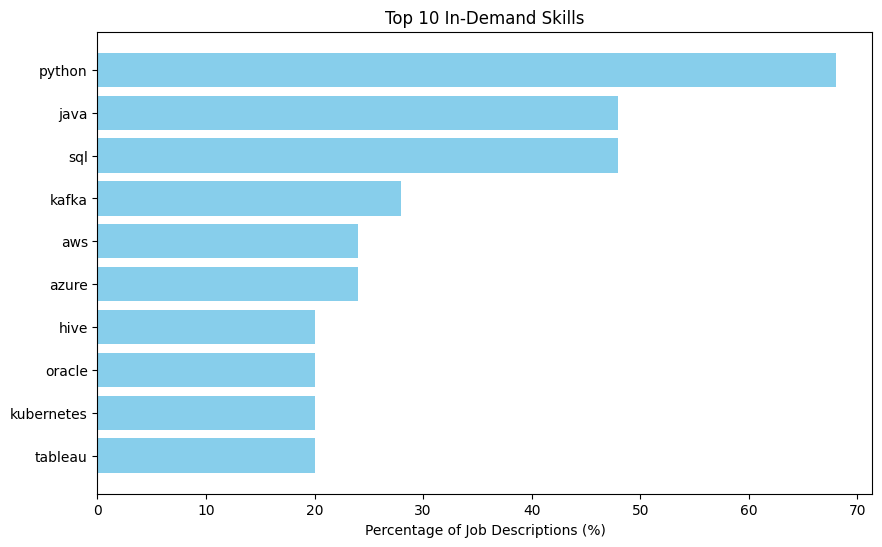

In [7]:
# flatten the list of skills from all job descriptions
all_skills = [skill for sublist in indeed_jobs['predicted_labels'] for skill in sublist]

# count the occurrences of each skill
# return a dictionary with the skill as key and count as the value
skill_counts = Counter(all_skills)

# calculate the percentage occurrence of each skill
total_jobs = len(indeed_jobs) # total jobs scraped
skill_percentages = {skill: (count / total_jobs) * 100 for skill, count in skill_counts.items()} # dict comprehension to create new dict with skills and corresponding %

# convert the dictionary to a DataFrame for easier manipulation
skill_df = pd.DataFrame.from_dict(skill_percentages, orient='index', columns=['Percentage']).reset_index()
skill_df = skill_df.rename(columns={'index': 'Skill'})

# sort the DataFrame by percentage in descending order and get the top 10 skills
top_skills = skill_df.sort_values(by='Percentage', ascending=False).head(10)

# plot the top 10 skills using a bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_skills['Skill'], top_skills['Percentage'], color='skyblue')
plt.xlabel('Percentage of Job Descriptions (%)')
plt.title('Top 10 In-Demand Skills')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest percentage at the top
plt.show()

#### Load Dataframe to Google BigQuery

In [10]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../xxxx.json" # replace with own service account key

from google.cloud import bigquery

# Initialize BigQuery client
client = bigquery.Client()

In [11]:
# Define the target BigQuery table

table_full_id = f"xxxx" # replace with own project-dataset-tableid

# Load the DataFrame into BigQuery
job = client.load_table_from_dataframe(indeed_jobs, table_full_id)
job.result()  # Wait for the job to complete

print(f"Loaded {job.output_rows} rows into BigQuery.")

Loaded 25 rows into BigQuery.
